In [99]:
# imports and settings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('seaborn-poster')

Research Question: What set of criteria is most important to the sucess of a mutual fund? What about amongst ETFs? Which type of fund is more successful overall?

Data overview:

The file contains 24,821 Mutual Funds and 1,680 ETFs with general aspects (as Total Net Assets, management company and size), portfolio indicators (as cash, stocks, bonds, and sectors), returns (as yeartodate, 2020-11) and financial ratios (as price/earning, Treynor and Sharpe ratios, alpha, and beta). This data was scraped from Yahoo Finance by kaggle user Stefano Leone.

Link to dataset: https://www.kaggle.com/stefanoleone992/mutual-funds-and-etfs


In [2]:
#loading data
#low_memory=False
df_mf=pd.read_csv('USData/Mutual Funds.csv')
df_etf=pd.read_csv('USData/ETFs.csv')


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (167,171) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


etfFile='USData/ETFs.csv'

fundFile='USData/Mutual Funds.csv'

 

df_mf=pd.read_csv(fundFile)

df_etf = pd.read_csv(etfFile)

def convert_dtype(x):
    if not x:
        return ''
    try:
        return str(x)   
    except:        
        return ''
types=[]
for col in df_mf.columns:
    types.extend(str(type(col)))
print(types[0:10])

df_mf=pd.read_csv(fundFile,converters={'first_column': convert_dtype,'second_column': convert_dtype})
etfs=pd.read_csv(etfFile,converters={'first_column': convert_dtype,'second_column': convert_dtype})

#drop empty cols in funds and etfs

""""
empty_cols = [col for col in funds.columns if funds[col].isnull().all()]

funds.drop(empty_cols,

        axis=1,

        inplace=True)

 

 

empty_cols2 = [col for col in etfs.columns if etfs[col].isnull().all()]

etfs.drop(empty_cols2,

        axis=1,

        inplace=True)
print("\nthese empty columns were dropped from etfs : " + str(empty_cols2))

 """""



In [3]:
#Removes a bunch of blank columns from the ETF dataframe. 
empt_cols=[col for col in df_etf.columns if df_etf[col].isnull().all()]
df_etf.drop(empt_cols,axis=1,inplace=True)
print("\nthese empty columns were dropped from etfs : " + str(empt_cols))


these empty columns were dropped from etfs : ['category_return_2019', 'category_return_2018', 'category_return_2017', 'category_return_2016']


In [4]:
df_mf.head()
#df_etf.columns

,fund_symbol,fund_extended_name,fund_family,inception_date,category,rating,return_rating,risk_rating,investment_strategy,investment_type,...,fund_sharpe_ratio_5years,category_sharpe_ratio_5years,fund_sharpe_ratio_10years,category_sharpe_ratio_10years,fund_treynor_ratio_3years,category_treynor_ratio_3years,fund_treynor_ratio_5years,category_treynor_ratio_5years,fund_treynor_ratio_10years,category_treynor_ratio_10years
0,AAAAX,DWS RREEF Real Assets Fund - Class A,DWS,2007-07-29,World Allocation,3.0,3.0,3.0,The investment seeks total return in excess of...,Blend,...,0.33,0.00,0.24,0.00,1.32,-0.00,2.77,0.03,1.91,0.04
1,AAADX,Aberdeen Income Builder Fund Class A,Aberdeen,2011-12-29,Allocation - 50% to 70% Equity,4.0,5.0,5.0,The investment seeks income; long-term growth ...,Blend,...,0.74,0.01,0.89,0.01,6.82,0.03,5.38,0.05,7.1,0.06
2,AAAGX,Thrivent Large Cap Growth Fund Class A,Thrivent Funds,1999-10-28,Large Growth,3.0,3.0,4.0,The investment seeks long-term capital appreci...,Growth,...,0.88,0.01,0.93,0.01,16.87,0.14,13.48,0.13,13.03,0.13
3,AAAIX,American Century Strategic Allocation: Aggress...,American Century Investments,2000-07-31,Allocation - 70% to 85% Equity,4.0,4.0,3.0,The investment seeks the highest level of tota...,Blend,...,0.61,0.00,0.73,0.01,3.7,0.02,5.05,0.04,5.87,0.05
4,AAANX,Horizon Active Asset Allocation Fund Investor ...,Horizon Investments,2012-01-30,Tactical Allocation,3.0,4.0,5.0,The investment seeks capital appreciation. The...,Blend,...,0.37,0.00,NaN,0.00,0.86,0.01,2.73,0.04,NaN,0.04


In [5]:
### Creates and returns a subset of df_mf by keeping only the columns with 'keyword' in their column name. 
def cleanbykeyword(df,keyword):
    col_list=[ i for i in df.columns if (keyword in i)] 
    #print(col_list)
    df_new=df[col_list]
    df.drop(columns=col_list,axis=1,inplace=True) #removes duplicate data from df_mf masterframe
    df_new.insert(0,'fund_symbol',df.fund_symbol) #inserts the fund symbols as the 1st column of the new data set
    return (df_new)

In [6]:
#Removes category data from the dataframe. Some of the category columns were not updated properly in the data set and therefore cannot be used in our analyses, we drop them to save space.
df_mf_category_data=cleanbykeyword(df_mf,'category_')
df_etf_category_data=cleanbykeyword(df_etf,'category_')

In [7]:
#cleaning by fund return
df_mf_return_history=cleanbykeyword(df_mf,'_return_')
df_mf_return_history.head(2)
df_etf_return_history=cleanbykeyword(df_etf,'_return_').dropna()
df_etf_return_history.head(2)
print([df_mf_return_history.columns])

[Index(['fund_symbol', 'fund_return_ytd', 'fund_return_1month',
       'fund_return_3months', 'fund_return_1year', 'fund_return_3years',
       'fund_return_5years', 'fund_return_10years', 'fund_return_2019',
       'fund_return_2018', 'fund_return_2017', 'fund_return_2016',
       'fund_return_2015', 'fund_return_2014', 'fund_return_2013',
       'fund_return_2012', 'fund_return_2011', 'fund_return_2010',
       'fund_return_2020_q3', 'fund_return_2020_q2', 'fund_return_2020_q1',
       'fund_return_2019_q4', 'fund_return_2019_q3', 'fund_return_2019_q2',
       'fund_return_2019_q1', 'fund_return_2018_q4', 'fund_return_2018_q3',
       'fund_return_2018_q2', 'fund_return_2018_q1', 'fund_return_2017_q4',
       'fund_return_2017_q3', 'fund_return_2017_q2', 'fund_return_2017_q1',
       'fund_return_2016_q4', 'fund_return_2016_q3', 'fund_return_2016_q2',
       'fund_return_2016_q1', 'fund_return_2015_q4', 'fund_return_2015_q3',
       'fund_return_2015_q2', 'fund_return_2015_q1', 'fund

In [8]:
#Cleaning by standard deviation
df_mf_standard_deviations= cleanbykeyword(df_mf,'standard_deviation')
df_etf_standard_deviations=cleanbykeyword(df_etf,'standard_deviation').dropna()
df_mf_standard_deviations.head(4)
df_etf_standard_deviations.head(4)

,fund_symbol,fund_standard_deviation_3years,fund_standard_deviation_5years,fund_standard_deviation_10years
0,1305,14.38,14.75,16.89
1,1306,14.38,14.75,16.83
2,1308,14.38,14.75,16.90
3,1310,15.16,16.21,18.39


In [9]:
#cleaning by net annual expense, Sharpe and Treynor Ratios
df_mf_ratios=cleanbykeyword(df_mf,'_ratio')
df_etf_ratios=cleanbykeyword(df_etf,'_ratio').dropna()
df_mf_ratios.head(4)
df_etf_ratios.head(4)

,fund_symbol,fund_net_annual_expense_ratio,price_earnings_ratio,price_book_ratio,price_sales_ratio,price_cashflow_ratio,fund_sharpe_ratio_3years,fund_sharpe_ratio_5years,fund_sharpe_ratio_10years,fund_treynor_ratio_3years,fund_treynor_ratio_5years,fund_treynor_ratio_10years
0,1305,0.00,12.92,1.18,0.81,5.41,0.34,0.59,0.60,3.92,8.01,9.29
1,1306,0.05,12.92,1.18,0.81,5.41,0.34,0.59,0.61,3.94,8.03,9.33
2,1308,0.00,12.92,1.18,0.81,5.44,0.34,0.59,0.60,3.93,8.03,9.31
3,1310,0.00,11.34,1.12,1.07,4.06,0.14,0.34,0.44,1.00,4.08,6.18


In [10]:
#cleaning by Alpha value 
df_mf_alpha=cleanbykeyword(df_mf,'alpha')
df_mf_alpha.head(4)
df_etf_alpha=cleanbykeyword(df_etf,'alpha')
df_etf_alpha.head(4)

,fund_symbol,fund_alpha_3years,fund_alpha_5years,fund_alpha_10years
0,1305,0.29,0.39,0.35
1,1306,0.31,0.40,0.38
2,1308,0.30,0.41,0.36
3,1310,-2.58,-3.41,-2.56


In [11]:
#cleaning by Beta value
df_mf_beta=cleanbykeyword(df_mf,'beta')
df_mf_beta.head(4)
df_etf_beta=cleanbykeyword(df_etf,'beta')
df_etf_beta.head(4)

,fund_symbol,fund_beta_3years,fund_beta_5years,fund_beta_10years
0,1305,1.00,0.98,0.99
1,1306,1.00,0.98,0.98
2,1308,1.00,0.98,0.99
3,1310,1.04,1.06,1.06


In [12]:
#cleaning by Sector 
df_mf_sector=cleanbykeyword(df_mf,'sector')
df_mf_sector.head(4)
df_etf_sector=cleanbykeyword(df_etf,'sector')
df_etf_sector.head(4)

,fund_symbol,sector_basic_materials,sector_consumer_cyclical,sector_financial_services,sector_real_estate,sector_consumer_defensive,sector_healthcare,sector_utilities,sector_communication_services,sector_energy,sector_industrials,sector_technology
0,1305,7.81,17.26,11.73,3.19,9.44,7.05,1.96,4.95,1.7,20.29,14.61
1,1306,7.81,17.26,11.73,3.19,9.43,7.06,1.96,4.95,1.7,20.29,14.62
2,1308,7.74,17.33,11.57,3.22,9.53,7.07,1.99,4.98,1.7,20.23,14.62
3,1310,2.41,14.25,16.26,1.74,7.93,4.55,0.00,15.52,2.0,16.26,19.06


In [13]:
#cleaning by Credit 
df_mf_credit=cleanbykeyword(df_mf,'credit').dropna()
df_mf_credit.head(4)

,fund_symbol,credit_us_government,credit_aaa,credit_aa,credit_a,credit_bbb,credit_bb,credit_b,credit_below_b,credit_other_ratings
3,AAAIX,0.0,57.15,5.64,10.26,13.63,6.82,4.78,1.02,0.70
7,AAARX,0.0,57.15,5.64,10.26,13.63,6.82,4.78,1.02,0.70
9,AAATX,0.0,66.37,4.40,8.79,9.01,5.64,3.23,1.09,1.47
10,AAAUX,0.0,57.15,5.64,10.26,13.63,6.82,4.78,1.02,0.70


In [14]:
#cleaning by r squared coefficient
df_mf_rsquare=cleanbykeyword(df_mf,'squared')
df_mf_rsquare.head(4)
df_etf_rsquare=cleanbykeyword(df_etf,'squared')
df_etf_rsquare.head(4)

,fund_symbol,fund_r_squared_3years,fund_r_squared_5years,fund_r_squared_10years
0,1305,99.72,99.70,99.68
1,1306,99.72,99.69,99.68
2,1308,99.72,99.69,99.68
3,1310,96.51,97.19,96.63


In [15]:
#cleaning by asset
df_mf_asset=cleanbykeyword(df_mf,'asset')
df_mf_asset.head(4)
df_etf_asset=cleanbykeyword(df_etf,'asset')
df_etf_asset.head(4)

,fund_symbol,asset_stocks,asset_bonds,net_asset_value
0,1305,100.00,0.0,4.010000e+12
1,1306,99.99,0.0,8.430000e+12
2,1308,99.08,0.0,3.730000e+12
3,1310,100.00,0.0,1.920000e+09


In [16]:
#Merges datasets containing R-Squares, Alpha, and Beta values into a single data set
df_mf_stats=df_mf_rsquare.merge(df_mf_alpha,how='left')
df_mf_stats=df_mf_stats.merge(df_mf_beta,how='left')
df_mf_stats.head()

df_etf_stats=df_etf_rsquare.merge(df_etf_alpha,how='left')
df_etf_stats=df_etf_stats.merge(df_etf_beta,how='left')
df_etf_stats.head()

,fund_symbol,fund_r_squared_3years,fund_r_squared_5years,fund_r_squared_10years,fund_alpha_3years,fund_alpha_5years,fund_alpha_10years,fund_beta_3years,fund_beta_5years,fund_beta_10years
0,1305,99.72,99.70,99.68,0.29,0.39,0.35,1.00,0.98,0.99
1,1306,99.72,99.69,99.68,0.31,0.40,0.38,1.00,0.98,0.98
2,1308,99.72,99.69,99.68,0.30,0.41,0.36,1.00,0.98,0.99
3,1310,96.51,97.19,96.63,-2.58,-3.41,-2.56,1.04,1.06,1.06
4,1311,96.52,97.20,96.64,-2.56,-3.39,-2.50,1.04,1.06,1.06


In [17]:
throwaway_cols=[
    'top10_holdings',
    'years_up',
    'years_down',
    'quarters_up',
    'quarters_down',
    'currency'
]
df_mf.drop(columns=throwaway_cols,axis=1,inplace=True)
df_etf.drop(columns=throwaway_cols,axis=1,inplace=True)

KeyError: "['quarters_up' 'quarters_down'] not found in axis"

In [ ]:
df_mf.head()
#print(df_mf.columns)

In [ ]:
df_mf_sector.head()

In [ ]:
#creates a pie chart representing the relative distribution of funds in a certain category 
def pie_chart(df,column):
    grouped=df.groupby(column).fund_symbol.count().to_frame()
    plt.pie(grouped.fund_symbol,labels=grouped.index,autopct='%.2f%%')
    plt.show()

In [ ]:
#Basic analysis of mutual fund distributions
plt.title('Size types of mutual funds')
pie_chart(df_mf,'size_type')
plt.title('Investment types of mutual funds')
pie_chart(df_mf,'investment_type')
plt.title('Risk Ratings of mutual funds')
pie_chart(df_mf,'risk_rating')


In [ ]:
#Basic analysis of ETF distributions
plt.title('Size types of ETFs')
pie_chart(df_etf,'size_type')
plt.title('Investment types of ETFs')
pie_chart(df_etf,'investment_type')
plt.title('Risk Ratings of ETFs')
pie_chart(df_etf,'risk_rating')


In [39]:
df_mf_asset.head()

,fund_symbol,asset_cash,asset_stocks,asset_bonds,asset_others,asset_preferred,asset_convertable,net_asset_value
0,AAAAX,1.88,63.87,15.31,18.95,0.00,0.00,6.979100e+08
1,AAADX,3.49,48.14,48.37,0.00,0.00,0.00,8.938000e+07
2,AAAGX,1.54,98.46,0.00,0.00,0.00,0.00,1.490000e+09
3,AAAIX,2.75,78.52,18.48,0.01,0.07,0.14,7.072500e+08
4,AAANX,1.54,98.45,0.00,0.01,0.00,0.00,4.955100e+08


[188380.04000000004, 1465715.42, 748196.7200000001, 30355.87, 8033.44, 19551.15]
[0.07657001087506912, 0.5957629356547354, 0.3041162481284697, 0.012338617700804098, 0.003265317218131046, 0.007946870422790586]


<BarContainer object of 6 artists>

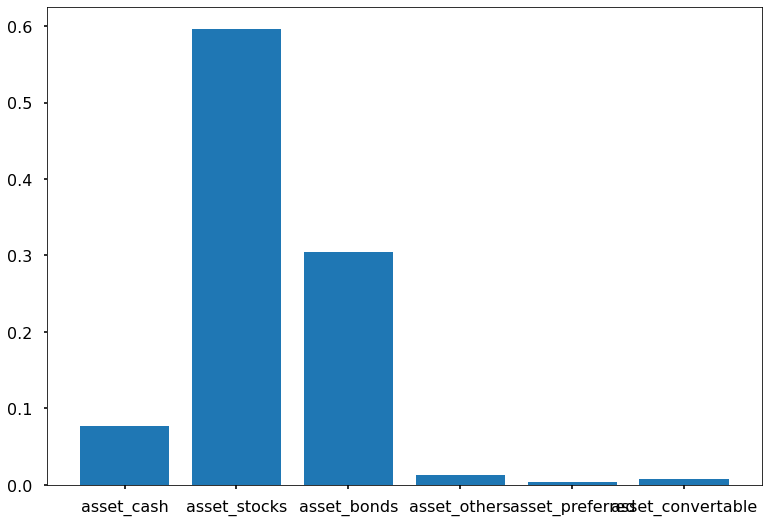

In [87]:

cols=[i for i in df_mf_asset.columns[1:7]]
total=0
col_sums=[]
for column in cols:
    col_sum=(df_mf_asset[column].sum())
    col_sums.append(col_sum)
    total+=col_sum
print(col_sums)    
col_percentages=[]
for i in range(0,6):
    col_percentages.append((col_sums[i]/total))
print(col_percentages)
plt.bar(cols,col_percentages)

KeyError: '%'

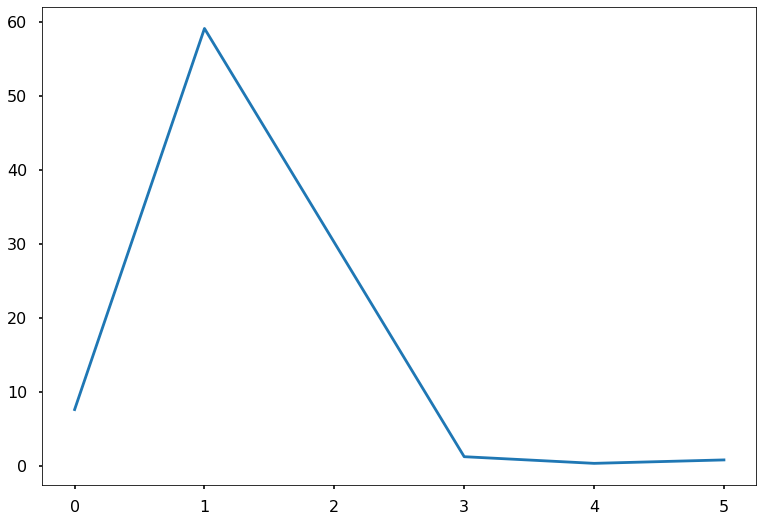

In [113]:

cols=[i for i in df_mf_asset.columns[1:7]]
total=0
col_sums=[]
fig,ax = plt.subplots()
for column in cols:
    col_sums.append(df_mf_asset[column].mean())
plt.plot(col_sums)
percents=np.arange(0,100,step=10)
ax.set_yticklabels('{%.2f}'.format(percents))
#xticks={:.2f%}.format(np.arange(0,100,step=10))
print(percents.vectorize("%.2f".__mod__)(sparse))